In [18]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

In [19]:
with rasterio.open(resolve_path(config['Africa_Cropland_tif_path'])) as src:
    cropland_data = src.read(1)
    # Convert to binary (0s and 1s) based on the threshold > 0
    cropland_binary = (cropland_data > 0).astype(np.uint8)

    # Define the metadata for the new binary TIFF file
    meta = src.meta
    meta.update(dtype=rasterio.uint8, nodata=None)

    # Save the binary data to a new TIFF file
    with rasterio.open(resolve_path(config['Cropland_tif_path']), 'w', **meta) as dst:
        dst.write(cropland_binary, 1)

print("Binary cropland data saved successfully.")

Binary cropland data saved successfully.


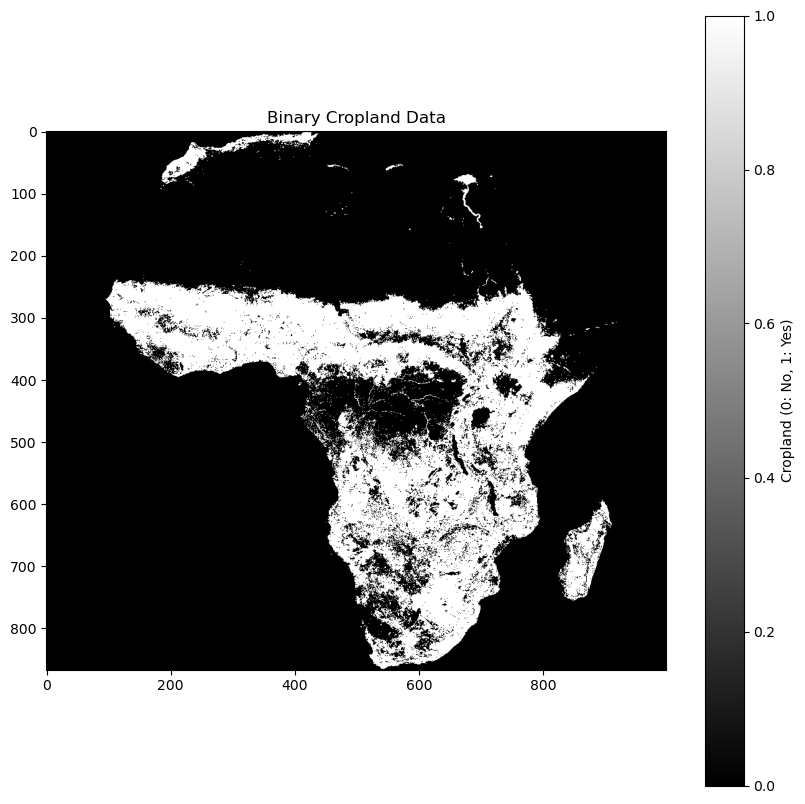

In [20]:
# Plot the binary cropland data
plt.figure(figsize=(10, 10))
plt.imshow(cropland_binary, cmap='gray')
plt.title('Binary Cropland Data')
plt.colorbar(label='Cropland (0: No, 1: Yes)')
plt.show()

#### Cropland masked by aridity data

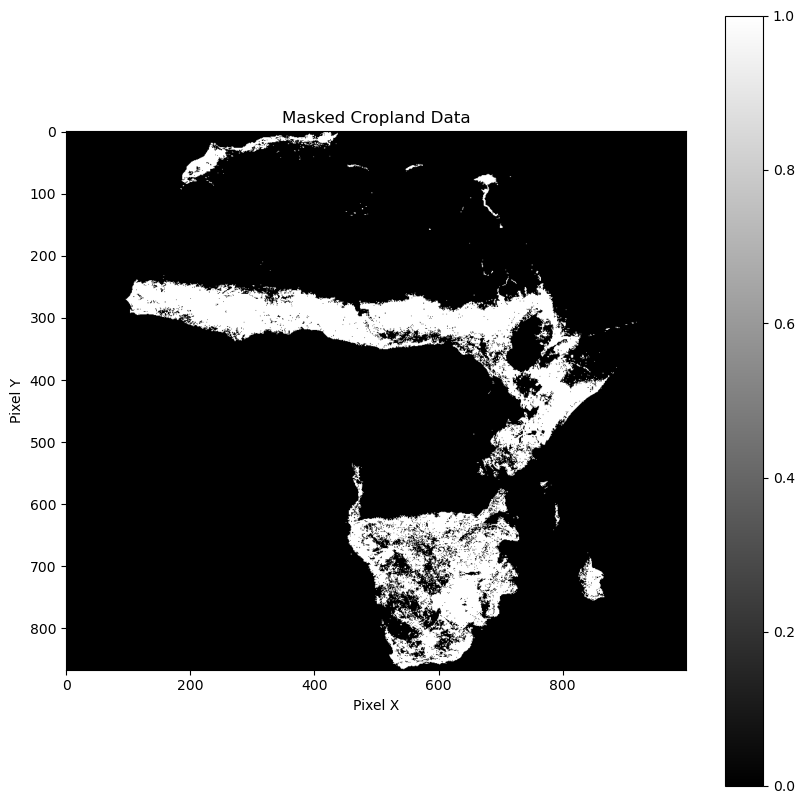

In [21]:
# Load the merged aridity and country boundary shapefile
aridity_gdf = gpd.read_file(resolve_path(config['Africa_Arid_by_Country_shp_path']))
aridity_gdf.set_crs(epsg=4326, inplace=True)

with rasterio.open(resolve_path(config['Cropland_tif_path'])) as src:
    cropland_binary = src.read(1)
    cropland_meta = src.meta

# Rasterize the merged shapefile
shapes = ((geom, 1) for geom in aridity_gdf.geometry)  
cropland_shape = cropland_binary.shape
transform = cropland_meta['transform']

aridity_raster = rasterize(
    shapes,
    out_shape = cropland_shape,
    transform = transform,
    fill = 0,
    dtype = 'uint8'
)

# Apply the mask to the cropland binary raster
cropland_aridity_binary_masked = cropland_binary * aridity_raster

# Plot the masked cropland data
plt.figure(figsize=(10, 10))
plt.imshow(cropland_aridity_binary_masked, cmap='gray')
plt.colorbar()
plt.title('Masked Cropland Data')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

cropland_meta.update(dtype = 'uint8')
with rasterio.open(resolve_path(config['Arid_Binary_Cropland_tif_path']), 'w', **cropland_meta) as dst:
    dst.write(cropland_aridity_binary_masked, 1)
    

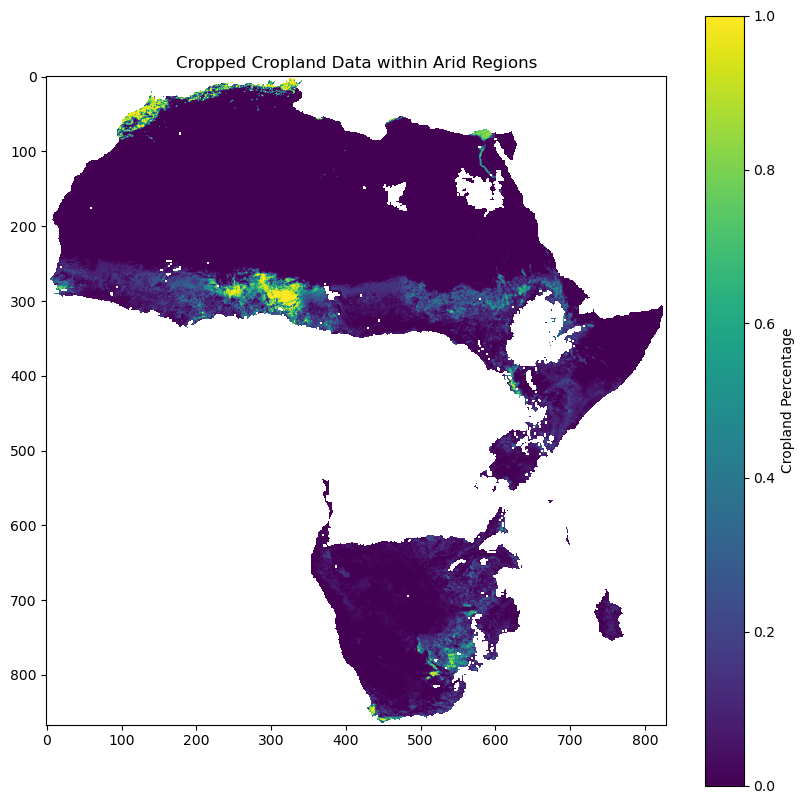

In [24]:
from rasterio.mask import mask

# Load the arid regions shapefile
arid_africa = gpd.read_file(resolve_path(config['Africa_all_shp_path']))

# Define the path to the raw cropland TIFF file
raw_cropland_tif_path = resolve_path(config['Africa_Cropland_tif_path'])

with rasterio.open(raw_cropland_tif_path) as raw_cropland_data:
    # Define a no-data value
    nodata_value = np.nan
    
    # Clip the cropland data to the extent of arid regions
    raw_cropland_clipped, raw_cropland_transform = mask(
        raw_cropland_data, arid_africa.geometry, crop=True, nodata=nodata_value, filled=True
    )
    
    # Update the metadata to include the no-data value
    raw_cropland_meta = raw_cropland_data.meta.copy()
    raw_cropland_meta.update({
        'height': raw_cropland_clipped.shape[1],
        'width': raw_cropland_clipped.shape[2],
        'transform': raw_cropland_transform,
        'nodata': nodata_value
    })

# Save the cropped cropland data with the no-data value
raw_cropland_clipped_path = resolve_path(config['Arid_Cropland_tif_path'])
with rasterio.open(raw_cropland_clipped_path, 'w', **raw_cropland_meta) as dst:
    dst.write(raw_cropland_clipped)

# Visualization to verify the result
import matplotlib.pyplot as plt

with rasterio.open(raw_cropland_clipped_path) as cropped_data:
    cropped_image = cropped_data.read(1)
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Cropland Percentage')
    plt.title('Cropped Cropland Data within Arid Regions')
    plt.show()
